In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt 

In [2]:
IMAGE_SIZE = 256 
BATCH_SIZE = 32

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage", 
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE), 
    batch_size = BATCH_SIZE
)
dataset

Found 2152 files belonging to 3 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

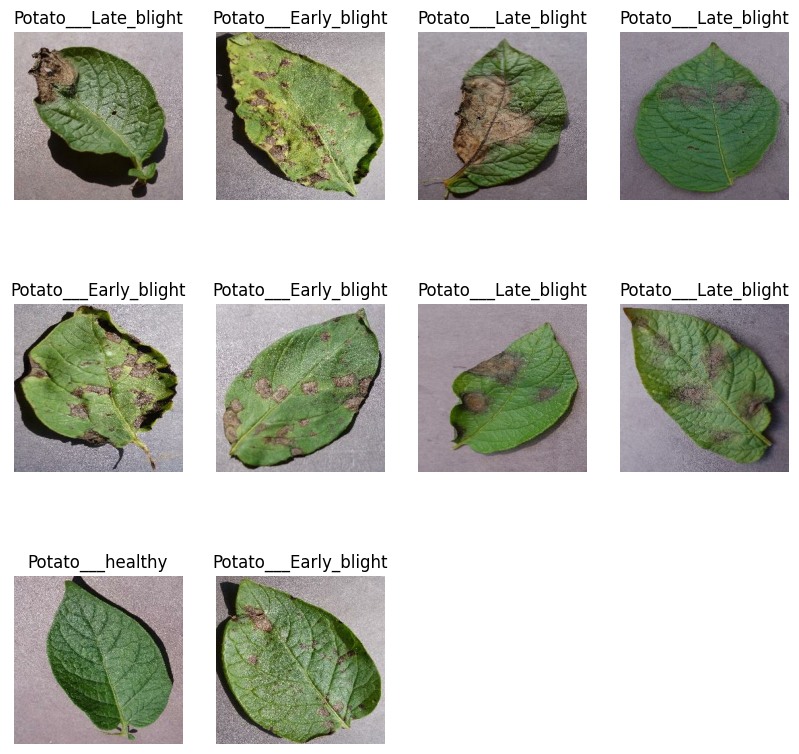

In [6]:
plt.figure(figsize = (10, 10)) 
for image_batch, label_batch in dataset.take(1):
    for i in range(10):
        plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
        

In [7]:
def get_dataset_partitions(ds, train_split=0.8, val_split=0.1, shuffle=True, shuffle_size = 10000 ):
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_samples = int(len(ds) * train_split)
    train_ds = ds.take(train_samples)
    
    val_size = int(len(ds) * val_split)
    val_ds = ds.skip(train_samples).take(val_size)
    
    test_ds = ds.skip(train_samples).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

len(train_ds)

54

In [9]:
len(test_ds)

8

In [10]:
%config IPCompleter.greedy=True

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [12]:
resize_and_rescale = tf.keras.Sequential([
    keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)
    
])

In [13]:
data_augmentation = tf.keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [14]:
input_shape = (BATCH_SIZE , IMAGE_SIZE, IMAGE_SIZE, 3)
model = keras.models.Sequential([
    resize_and_rescale, 
    data_augmentation, 
    keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = input_shape),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(), 
    keras.layers.Dense(64, activation = 'relu'), 
    keras.layers.Dense(3, activation = 'softmax'),
    
])

model.build(
    input_shape=input_shape
)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [16]:
model.compile(
    optimizer = 'adam',
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = False), 
    metrics = ['accuracy']
)

In [17]:
history = model.fit(
    train_ds, 
    epochs = 10, 
    batch_size = BATCH_SIZE, 
    verbose=1,
    validation_data = val_ds
)


Epoch 1/10
54/54 [==============================] - 65s 1s/step - loss: 0.8665 - accuracy: 0.5006 - val_loss: 0.8055 - val_accuracy: 0.5990
Epoch 2/10
54/54 [==============================] - 100s 2s/step - loss: 0.5919 - accuracy: 0.7506 - val_loss: 0.5433 - val_accuracy: 0.7552
Epoch 3/10
54/54 [==============================] - 126s 2s/step - loss: 0.3828 - accuracy: 0.8559 - val_loss: 0.3624 - val_accuracy: 0.8802
Epoch 4/10
54/54 [==============================] - 71s 1s/step - loss: 0.3299 - accuracy: 0.8704 - val_loss: 0.2784 - val_accuracy: 0.9010
Epoch 5/10
54/54 [==============================] - 75s 1s/step - loss: 0.1914 - accuracy: 0.9311 - val_loss: 0.2181 - val_accuracy: 0.9323
Epoch 6/10
54/54 [==============================] - 158s 3s/step - loss: 0.2594 - accuracy: 0.8964 - val_loss: 0.4206 - val_accuracy: 0.8125
Epoch 7/10
54/54 [==============================] - 91s 2s/step - loss: 0.1950 - accuracy: 0.9265 - val_loss: 0.1708 - val_accuracy: 0.9479
Epoch 8/10
54/54 

In [18]:
model.evaluate(test_ds)

8/8 [==============================] - 4s 266ms/step - loss: 0.1085 - accuracy: 0.9570


[0.10849664360284805, 0.95703125]

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


acc, val_acc

([0.5005787014961243,
  0.7505787014961243,
  0.8559027910232544,
  0.8703703880310059,
  0.9311342835426331,
  0.8964120149612427,
  0.9265046119689941,
  0.9415509104728699,
  0.9479166865348816,
  0.9392361044883728],
 [0.5989583134651184,
  0.7552083134651184,
  0.8802083134651184,
  0.9010416865348816,
  0.9322916865348816,
  0.8125,
  0.9479166865348816,
  0.9114583134651184,
  0.9322916865348816,
  0.9583333134651184])

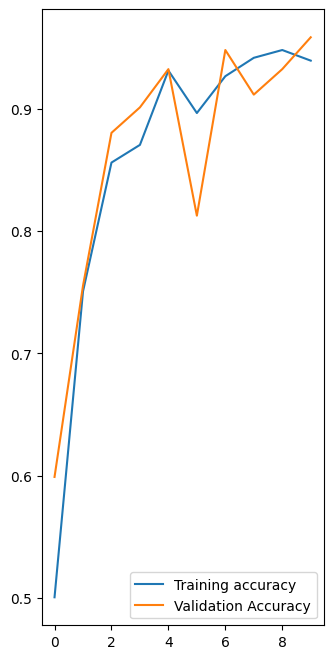

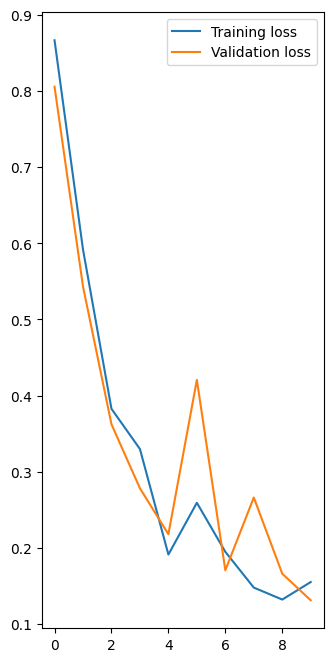

In [20]:
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(10), acc, label='Training accuracy')
plt.plot(range(10), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 2)
plt.plot(range(10), loss, label='Training loss')
plt.plot(range(10), val_loss, label='Validation loss')
plt.legend(loc='upper right')

In [21]:
import numpy as np
for image_batch, label_batch in test_ds.take(1):
    actual_class = class_names[label_batch[6]]
    print('actual class is : ', actual_class)
    predicted_class = model.predict(image_batch)
    print('predicted class is : ', class_names[np.argmax(predicted_class[6])])
    

actual class is :  Potato___Early_blight
1/1 [==============================] - 1s 606ms/step
predicted class is :  Potato___Early_blight


In [22]:
def predict(model, img): 
    img_array = keras.preprocessing.image.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array, 0) 
    
    predictions = model.predict(img_array) 
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 35ms/step


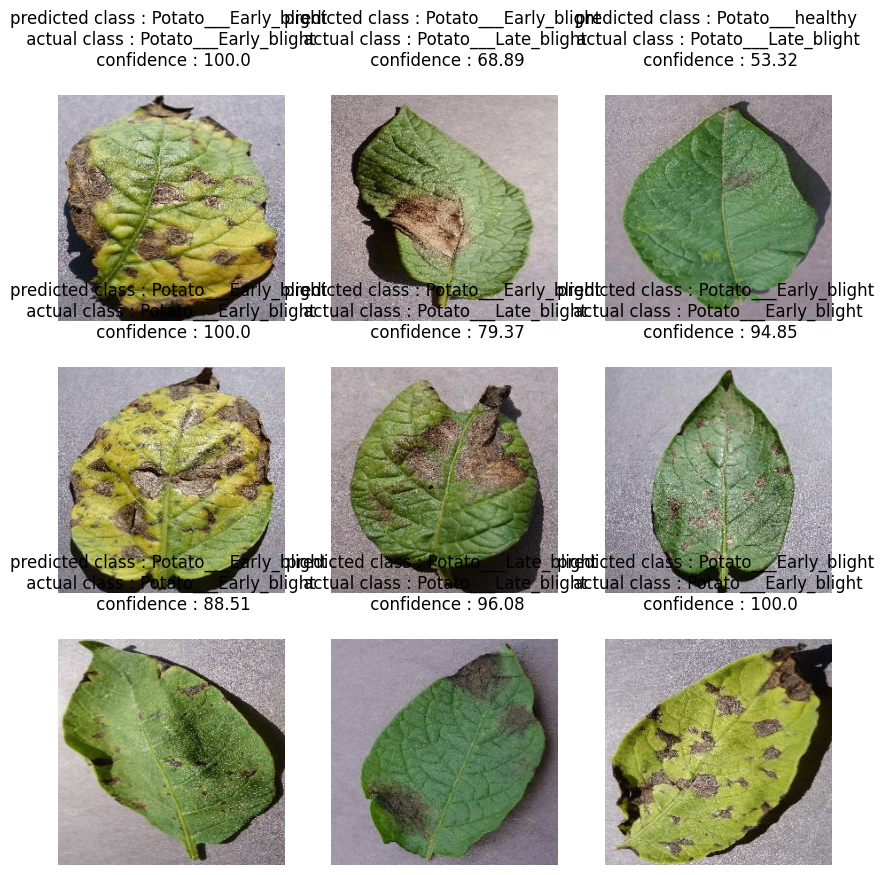

In [23]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, image_batch[i])
        plt.title(f'predicted class : {predicted_class} \n actual class : {class_names[label_batch[i]]} \n confidence : {confidence}\n')
        plt.axis('off')
        

In [25]:

model.save("../potatoes1.h5")

In [27]:
import os
for i in os.listdir("../saved_models"):
    print(int(i))
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

1
2


INFO:tensorflow:Assets written to: ../saved_models/3\assets


INFO:tensorflow:Assets written to: ../saved_models/3\assets
